# Modelo Previsão Tempo Total

ESTE PROGRAMA IDENTIFICA O NÚMERO DE EXPEDIENTES TRAMITADOS POR SITUAÇÃO PARA A GGTOX 
PARA MEDIR A QUANTIDADE DE TRABALHO DEMANDADO, PRODUTIVIDADE DA ÁREA 
NUMERO DE ENTRADAS E FINALIZAÇÕES DE EXPEDIENTES POR ANO E MES 
ANALISA O TEMPO MÉDIO DE ANÁLISE DOS PROCESSOS CONSIDERANDO AS EXIGÊNCIAS FEITAS E O TEMPO DE FILA PARA ANÁLISE 

FONTES: 
1. RELATÓRIO SITUAÇÕES DE EXPEDIENTES DO DATAVISA-DV (SQLSERVER)
2. TABELA 'DE PARA' CÓDIGOS DE ASSUNTOS - 
3. TABELA 'DE PARA' SITUAÇÃO DOS PROCESSOS 
4. CRITÉRIOS PARA FILA
 
SAIDA: ARQUIVOS TXT PARA MONTAR A PUBLICAÇÃO NO SEI
 
Versões - Atualizações

1. Criado em 13/02/2023 



In [1]:
#pip install pyodbc
# importar bibliotecas
import pandas as pd
import numpy as np
import io

# 2. MODELANDO

In [2]:
df_0   = pd.read_excel(r'C:\Users\alesa\OneDrive - ANVISA - Agencia Nacional de Vigilancia Sanitaria\000_ECD\TCC\Dados\df.xlsx',
                         header=0, sheet_name="Planilha1")

df_0['DATA_FINALIZACAO'] = df_0['DT_FINALIZACAO'].dt.date
df_0['DATA_FINALIZACAO_AM'] = df_0['DT_FINALIZACAO'].dt.strftime('%Y-%m')

df_41 = pd.DataFrame(df_0[(df_0['CO_ASSUNTO'] == 5041)]) 
df_65 = pd.DataFrame(df_0[(df_0['CO_ASSUNTO'] == 5065)]) 

#df = df_0.groupby(['CO_ASSUNTO','CO_ASSUNTO_T','DATA_FINALIZACAO'])['TOTAL'].mean().reset_index()
df =    df_0.groupby(['CO_ASSUNTO','CO_ASSUNTO_T','DATA_FINALIZACAO_AM'])['TOTAL'].mean().reset_index()
df41 = df_41.groupby(['CO_ASSUNTO','CO_ASSUNTO_T','DATA_FINALIZACAO_AM'])['TOTAL'].mean().reset_index()
df65 = df_65.groupby(['CO_ASSUNTO','CO_ASSUNTO_T','DATA_FINALIZACAO_AM'])['TOTAL'].mean().reset_index()

df65.head()


,CO_ASSUNTO,CO_ASSUNTO_T,DATA_FINALIZACAO_AM,TOTAL
0,5065,5065,2014-05,2358.000000
1,5065,5065,2014-06,51.000000
2,5065,5065,2015-10,4950.000000
3,5065,5065,2015-11,1102.000000
4,5065,5065,2015-12,1812.941176


In [3]:
# Verificando a estacionaridade da série

from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt


In [8]:
#result = adfuller(df['TOTAL'])
result41 = adfuller(df41['TOTAL'])
result65 = adfuller(df65['TOTAL'])

# Extraia os resultados do teste
#p_value = result[1]
p_value41 = result41[1]
p_value65 = result65[1]


# Imprima os resultados
#print(f"Valor p: {p_value}")
print(f"Valor p41: {p_value41}")
print(f"Valor p65: {p_value65}")


Valor p41: 0.011022706431745681
Valor p65: 0.0002491862947946675


In [9]:
# Verificar a estacionariedade com valor-p
#if p_value < 0.05:
#    print("A série é estacionária.")
#else:
#    print("A série não é estacionária.")
    
if p_value41 < 0.05:
    print("A série41 é estacionária.")
else:
    print("A série41 não é estacionária.")
    
if p_value65 < 0.05:
    print("A série65 é estacionária.")
else:
    print("A série65 não é estacionária.")

A série41 é estacionária.
A série65 é estacionária.


In [25]:
#### Gráficos ACF e PACF
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [10]:
# Definir a coluna ano como índice
df41.set_index('DATA_FINALIZACAO_AM',inplace=True)
# Alterar o nome do índice de Any para ano
# Alterar o nome do índice de Any para ano
df41.index.name = 'AnoMes'
df41 = df41[['TOTAL']]

In [11]:
# Definir a coluna ano como índice
df65.set_index('DATA_FINALIZACAO_AM',inplace=True)
# Alterar o nome do índice de Any para ano
# Alterar o nome do índice de Any para ano
df65.index.name = 'AnoMes'
df65 = df65[['TOTAL']]

In [12]:
df65.head()

,TOTAL
AnoMes,
2014-05,2358.000000
2014-06,51.000000
2015-10,4950.000000
2015-11,1102.000000
2015-12,1812.941176


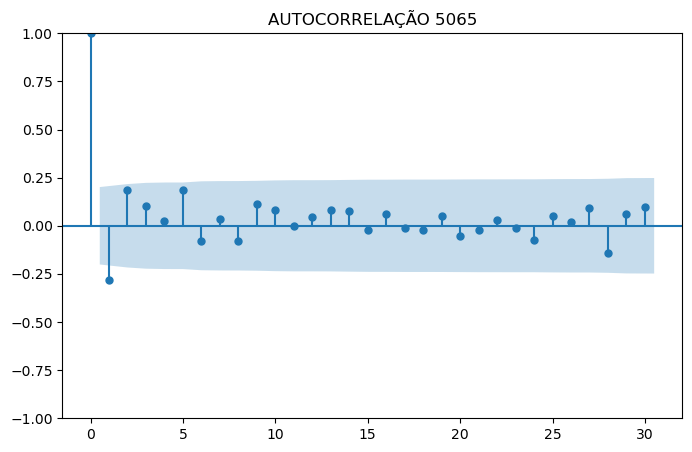

In [64]:

fig, ax = plt.subplots(figsize=(8,5))
plot_acf(df65['TOTAL'], lags=30, ax=ax)
plt.title('AUTOCORRELAÇÃO 5065')
plt.show()


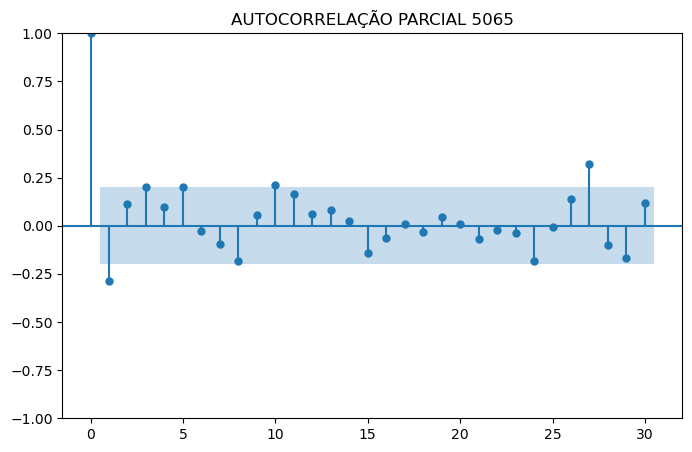

In [63]:
fig, ax = plt.subplots(figsize=(8,5))
plot_pacf(df65['TOTAL'], lags=30, ax=ax)
plt.title('AUTOCORRELAÇÃO PARCIAL 5065')
plt.show()

In [13]:
# AUTOREGRESSIVO
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg

In [26]:
ar_modelo = AutoReg(df41[['TOTAL']], lags=2).fit()
ar_modelo.summary()

C:\Users\alesa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  TOTAL   No. Observations:                  113
Model:                     AutoReg(2)   Log Likelihood                -828.162
Method:               Conditional MLE   S.D. of innovations            420.725
Date:                Sat, 15 Jul 2023   AIC                           1664.324
Time:                        11:21:44   BIC                           1675.162
Sample:                             2   HQIC                          1668.721
                                  113                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        646.2557    137.250      4.709      0.000     377.251     915.260
TOTAL.L1       0.2980      0.090      3.302      0.001       0.121       0.475
TOTAL.L2       0.2587      0.088      2.927      0.003       0.085       0.432
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4727           +0.0000j            1.4727            0.0000
AR.2           -2.6247           +0.0000j            2.6247            0.5000
-----------------------------------------------------------------------------
"""

In [21]:
pred = ar_modelo.predict(start=len(df65), end=len(df65)+2, dynamic=False)
pred

C:\Users\alesa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\alesa\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


95    1941.616409
96    2010.627914
97    1967.627973
dtype: float64

In [69]:
import statsmodels.api as sm


In [89]:
#MODELO MA
modelo_ma = sm.tsa.arima.ARIMA(df65[['TOTAL']], order=(0,0,1)) # Ordem do modelo MA (p, d, q)
resultado_ma = modelo_ma.fit()
print(resultado_ma.summary())

                               SARIMAX Results                                
Dep. Variable:                  TOTAL   No. Observations:                   95
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -730.769
Date:                Sat, 15 Jul 2023   AIC                           1467.537
Time:                        00:09:34   BIC                           1475.199
Sample:                             0   HQIC                          1470.633
                                 - 95                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1964.8678     52.218     37.628      0.000    1862.523    2067.213
ma.L1         -0.2044      0.091     -2.249      0.025      -0.383      -0.026
sigma2       2.81e+05   2.99e+04      9.407      0.0

C:\Users\alesa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alesa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alesa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [90]:
#MODELO ARMA
modelo_ma = sm.tsa.arima.ARIMA(df65[['TOTAL']], order=(0,1,1)) # Ordem do modelo MA (p, d, q)

resultado_ma = modelo_ma.fit()
print(resultado_ma.summary())

                               SARIMAX Results                                
Dep. Variable:                  TOTAL   No. Observations:                   95
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -727.027
Date:                Sat, 15 Jul 2023   AIC                           1458.054
Time:                        00:09:57   BIC                           1463.140
Sample:                             0   HQIC                          1460.108
                                 - 95                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9506      0.059    -16.043      0.000      -1.067      -0.834
sigma2      2.988e+05   2.47e+04     12.122      0.000     2.5e+05    3.47e+05
Ljung-Box (L1) (Q):                  10.45   Jarque-

C:\Users\alesa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alesa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alesa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# MODELO SELECIONADO AR


In [22]:
pred = ar_modelo.predict(start=len(df65), end=len(df65)+3, dynamic=False)
pred

C:\Users\alesa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\alesa\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


95    1941.616409
96    2010.627914
97    1967.627973
98    1985.608439
dtype: float64

C:\Users\alesa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alesa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\alesa\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


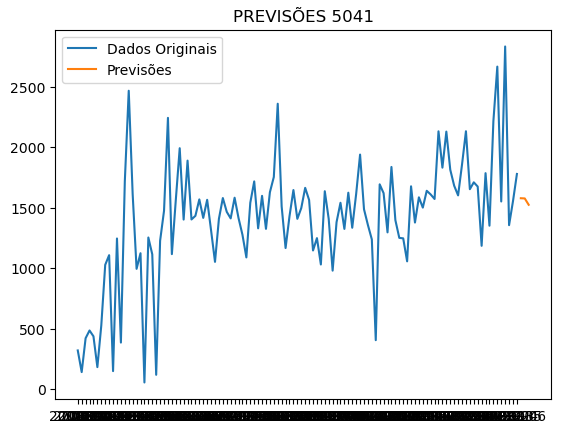

In [28]:
# Gráfico de previsão

# Ajustar o modelo ARIMA aos dados
#model = ARIMA(df41['TOTAL'], order=order)
#model_fit = model.fit()

ar_modelo = AutoReg(df41[['TOTAL']], lags=2).fit()
#modelo_ma = sm.tsa.arima.ARIMA(df65[['TOTAL']], order=(0,0,1)) # Ordem do modelo MA (p, d, q)

# Fazer previsões
n_steps = 3  # Número de passos futuros a serem previstos
forecast = ar_modelo.forecast(steps=n_steps)
#forecast1 = modelo_ma.forecast(steps=n_steps)

# Plotar os dados originais e as previsões
plt.plot(df41['TOTAL'], label='Dados Originais')
#plt.plot(np.arange(len(df65['TOTAL']), len(df65['TOTAL']) + n_steps), forecast, forecast1, label='Previsões')
plt.plot(np.arange(len(df41['TOTAL']), len(df41['TOTAL']) + n_steps), forecast, label='Previsões')
plt.title('PREVISÕES 5041')
plt.legend()
plt.show()

## MODELO ARIMA

In [11]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

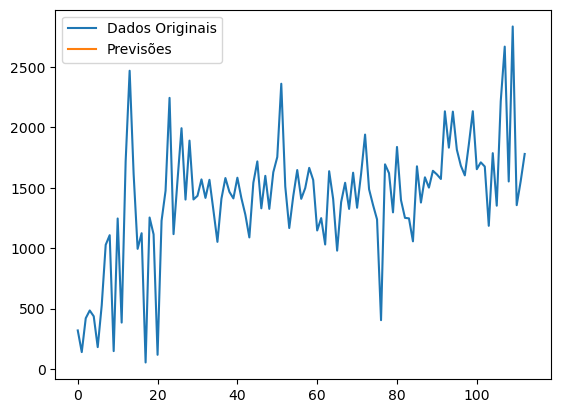

In [13]:

# Definir os parâmetros do modelo ARIMA
order = (1, 1, 1)  # Ordem do modelo ARIMA (p, d, q)

# Ajustar o modelo ARIMA aos dados
model = ARIMA(df41['TOTAL'], order=order)
model_fit = model.fit()

# Fazer previsões
n_steps = 1  # Número de passos futuros a serem previstos
forecast = model_fit.forecast(steps=n_steps)

# Plotar os dados originais e as previsões
plt.plot(df41['TOTAL'], label='Dados Originais')
plt.plot(np.arange(len(df41['TOTAL']), len(df41['TOTAL']) + n_steps), forecast, label='Previsões')
plt.legend()
plt.show()


In [9]:
forecast

113    1819.079402
114    1822.796355
115    1823.146781
116    1823.179818
117    1823.182933
118    1823.183227
119    1823.183254
120    1823.183257
121    1823.183257
122    1823.183257
123    1823.183257
124    1823.183257
Name: predicted_mean, dtype: float64

In [27]:
# Para calcular o Mean Squared Error (MSE) em um modelo ARIMA

# Separar os dados em treinamento e teste
train_data = df41.iloc[:-2]
test_data = df41.iloc[-2:]

order = (1, 1, 1)  # Ordem do modelo ARIMA (p, d, q)

# Ajustar o modelo ARIMA aos dados
model = ARIMA(df41['TOTAL'], order=order)
model_fit = model.fit()

# Fazer as previsões para os dados de teste
predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

# Calcular o MSE
mse = np.mean((predictions - test_data['TOTAL']) ** 2)

print('Mean Squared Error (MSE):', mse)

Mean Squared Error (MSE): 39580.73572293273


### Random Forest

In [12]:
#carregar bibliotecas para a modelagem
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

In [28]:
# Modelo Random forest de Previsão
x = pd.DataFrame(df[['CO_ASSUNTO_T',
                     #'DT_ENTRADA',
                     #'DT_FINALIZACAO'
                    ]])
y = df['TOTAL']

#Particionar base de dados
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Definir parâmetros do modelo
#modelo = RandomForestClassifier(n_estimators=100, random_state=0)
modelo = RandomForestRegressor()
#Ajustar o modelo
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mse
# total 651325.3324850077
1085455.8111931058

1085455.8111931058

In [29]:
#Realizar a previsão do modelo

X = pd.DataFrame(df[['CO_ASSUNTO_T',
                     #'RECURSO',
                     #'CANCELADO',
                     #'DT_ENTRADA',
                     #'DT_FINALIZACAO'
                    ]])
y = df['TOTAL']


# Crie uma instância do modelo Random Forest e ajuste-o aos dados
rf = RandomForestRegressor()
rf.fit(X, y)

# Faça as previsões usando o modelo treinado
y_pred = rf.predict(X)

# Adicione as previsões ao DataFrame original
df['y_pred'] = y_pred

# Exiba o DataFrame com as previsões
df.head()


,CO_ASSUNTO,CO_ASSUNTO_T,DATA_FINALIZACAO_AM,TOTAL,y_pred
0,5041,5041,2008-01,320.0,1412.386485
1,5041,5041,2008-04,141.0,1412.386485
2,5041,5041,2008-08,421.0,1412.386485
3,5041,5041,2008-11,485.0,1412.386485
4,5041,5041,2008-12,437.0,1412.386485


### Arvore de Decisão


In [30]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [31]:
# Modelo Random forest de Previsão
x = pd.DataFrame(df[['CO_ASSUNTO_T',
                     #'RECURSO',
                     #'CANCELADO',
                     #'DT_ENTRADA',
                     #'DT_FINALIZACAO'
                    ]])
y = df['TOTAL']

#Particionar base de dados
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Definir parâmetros do modelo
#modelo = RandomForestClassifier(n_estimators=100, random_state=0)
dt = DecisionTreeRegressor()
#Ajustar o modelo
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mse

#A interpretação do MSE é que ele mede a média dos erros ao quadrado, portanto, 
#quanto menor o valor do MSE, melhor é o ajuste do modelo aos dados. 
#Um MSE igual a zero indica que o modelo é capaz de fazer previsões perfeitas, 
#correspondendo exatamente aos valores reais.

#total 652522.7518934308

152228.60401865334

### Modelo de Regressão paramétrica




In [16]:
import statsmodels.api as sm

In [32]:
# Modelo Random forest de Previsão
X = pd.DataFrame(df[['CO_ASSUNTO',
                     #'RECURSO',
                     #'CANCELADO',
                     #'DT_ENTRADA',
                     #'DT_FINALIZACAO'
                    ]])
y = df['TOTAL']

# Adicione uma coluna constante para o termo de interceptação
X = sm.add_constant(X)

# Crie o modelo de regressão linear
model = sm.OLS(y, X)

# Ajuste o modelo aos dados
results = model.fit()

# Imprima os resultados da regressão
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  TOTAL   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     56.95
Date:                Thu, 06 Jul 2023   Prob (F-statistic):           1.42e-12
Time:                        11:37:15   Log-Likelihood:                -1597.8
No. Observations:                 208   AIC:                             3200.
Df Residuals:                     206   BIC:                             3206.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.149e+05   1.54e+04     -7.439      0.0

### Modelo de Redes Neurais


In [18]:
#!pip install tensorflow
# uma biblioteca poderosa e abrangente para o desenvolvimento de modelos de aprendizado de máquina e redes neurais.

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler


In [33]:
# Carregando os dados de exemplo (série temporal)
data = df

# Pré-processamento dos dados
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['TOTAL'].values.reshape(-1, 1))

# Divisão dos dados em treinamento e teste
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


# Função para criar o conjunto de dados de entrada e saída
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)


In [20]:
# Definição do número de passos de tempo e criação dos conjuntos de treinamento e teste
time_steps = 10
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Construção do modelo de redes neurais
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Treinamento do modelo
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Previsão com o modelo treinado
y_pred = model.predict(X_test)

# Inversão da escala dos dados previstos
y_pred = scaler.inverse_transform(y_pred)

# Avaliação do desempenho do modelo (por exemplo, MSE)
mse = np.mean((y_test - y_pred)**2)
print(f'MSE: {mse}')
# MSE: 2968198.7207129532 - TOTAL




Epoch 1/10
3/3 [==============================] - 2s 7ms/step - loss: 0.1435
Epoch 2/10
3/3 [==============================] - 0s 5ms/step - loss: 0.1270
Epoch 3/10
3/3 [==============================] - 0s 5ms/step - loss: 0.1108
Epoch 4/10
3/3 [==============================] - 0s 6ms/step - loss: 0.0947
Epoch 5/10
3/3 [==============================] - 0s 5ms/step - loss: 0.0795
Epoch 6/10
3/3 [==============================] - 0s 5ms/step - loss: 0.0642
Epoch 7/10
3/3 [==============================] - 0s 5ms/step - loss: 0.0494
Epoch 8/10
3/3 [==============================] - 0s 6ms/step - loss: 0.0366
Epoch 9/10
3/3 [==============================] - 0s 6ms/step - loss: 0.0265
Epoch 10/10
1/1 [==============================] - 0s 212ms/step
MSE: 3304755.5850232267


# Medias moveis
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\alesa\AppData\Local\Temp\ipykernel_18172\3586516551.py:16: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  df_extenso = pd.concat([df, pd.DataFrame(index=pd.date_range(start=df.index[-1], periods=num_valores_futuros+1, closed='right')[1:])])


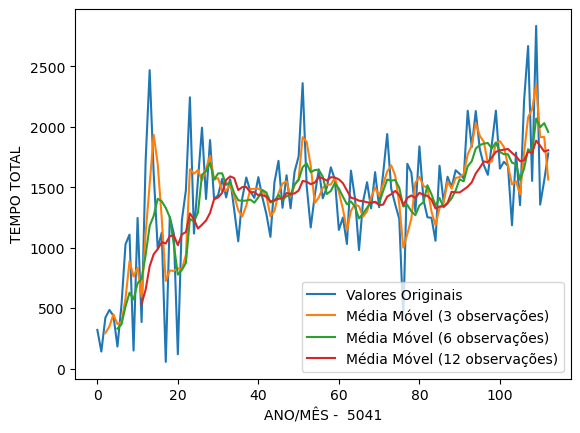

,PREV3,PREV6,PREV12,CO_ASSUNTO
112,1563.553461,1957.402833,1805.867225,5041


In [48]:
# Suponha que você tenha um DataFrame chamado df com uma coluna 'valores'
# Substitua 'df' pelo nome do seu DataFrame e 'valores' pelo nome da coluna que deseja aplicar as médias móveis

import matplotlib.pyplot as plt

df = df41
df = df.rename(columns={'TOTAL': 'valores'})

# Defina os tamanhos das janelas
window1 = 3
window2 = 6
window3 = 12

# Estenda o DataFrame com valores futuros
num_valores_futuros = 1
df_extenso = pd.concat([df, pd.DataFrame(index=pd.date_range(start=df.index[-1], periods=num_valores_futuros+1, closed='right')[1:])])


# Calcule as médias móveis com as duas janelas
df['media_movel1'] = df['valores'].rolling(window=window1).mean()
df['media_movel2'] = df['valores'].rolling(window=window2).mean()
df['media_movel3'] = df['valores'].rolling(window=window3).mean()

# Plote os valores originais e as médias móveis
plt.plot(df['valores'], label='Valores Originais')
plt.plot(df['media_movel1'], label=f'Média Móvel ({window1} observações)')
plt.plot(df['media_movel2'], label=f'Média Móvel ({window2} observações)')
plt.plot(df['media_movel3'], label=f'Média Móvel ({window3} observações)')

# Adicione rótulos aos eixos x e y e uma legenda
plt.xlabel('ANO/MÊS -  5041')
plt.ylabel('TEMPO TOTAL')
plt.legend()

# Exiba o gráfico
plt.show()

# Acesse os valores previstos para o futuro para cada janela
valores_previstos_futuros_janela1 = df['media_movel1'][-num_valores_futuros:]
valores_previstos_futuros_janela2 = df['media_movel2'][-num_valores_futuros:]
valores_previstos_futuros_janela3 = df['media_movel3'][-num_valores_futuros:]


df_previstos41 = pd.DataFrame({
    'PREV3': valores_previstos_futuros_janela1,
    'PREV6': valores_previstos_futuros_janela2,
    'PREV12': valores_previstos_futuros_janela3
})

df_previstos41['CO_ASSUNTO'] = 5041

# Imprima o novo DataFrame
df_previstos41.head()

C:\Users\alesa\AppData\Local\Temp\ipykernel_18172\4090143862.py:16: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  df_extenso = pd.concat([df, pd.DataFrame(index=pd.date_range(start=df.index[-1], periods=num_valores_futuros+1, closed='right')[1:])])


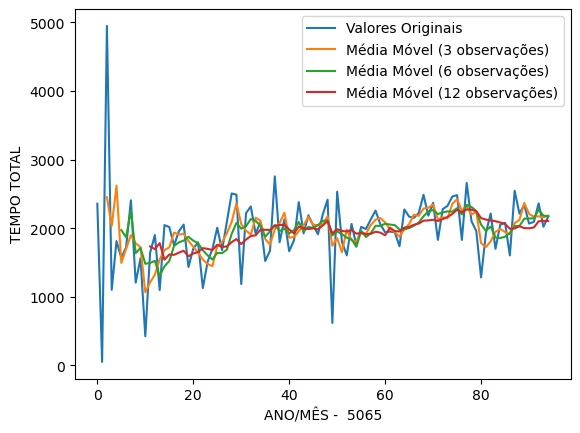

,PREV3,PREV6,PREV12,CO_ASSUNTO
94,2184.514687,2176.392203,2104.363463,5065


In [50]:
# Suponha que você tenha um DataFrame chamado df com uma coluna 'valores'
# Substitua 'df' pelo nome do seu DataFrame e 'valores' pelo nome da coluna que deseja aplicar as médias móveis

import matplotlib.pyplot as plt

df = df65
df = df.rename(columns={'TOTAL': 'valores'})

# Defina os tamanhos das janelas
window1 = 3
window2 = 6
window3 = 12

# Estenda o DataFrame com valores futuros
num_valores_futuros = 1
df_extenso = pd.concat([df, pd.DataFrame(index=pd.date_range(start=df.index[-1], periods=num_valores_futuros+1, closed='right')[1:])])


# Calcule as médias móveis com as duas janelas
df['media_movel1'] = df['valores'].rolling(window=window1).mean()
df['media_movel2'] = df['valores'].rolling(window=window2).mean()
df['media_movel3'] = df['valores'].rolling(window=window3).mean()

# Plote os valores originais e as médias móveis
plt.plot(df['valores'], label='Valores Originais')
plt.plot(df['media_movel1'], label=f'Média Móvel ({window1} observações)')
plt.plot(df['media_movel2'], label=f'Média Móvel ({window2} observações)')
plt.plot(df['media_movel3'], label=f'Média Móvel ({window3} observações)')

# Adicione rótulos aos eixos x e y e uma legenda
plt.xlabel('ANO/MÊS -  5065')
plt.ylabel('TEMPO TOTAL')
plt.legend()

# Exiba o gráfico
plt.show()

# Acesse os valores previstos para o futuro para cada janela
valores_previstos_futuros_janela1 = df['media_movel1'][-num_valores_futuros:]
valores_previstos_futuros_janela2 = df['media_movel2'][-num_valores_futuros:]
valores_previstos_futuros_janela3 = df['media_movel3'][-num_valores_futuros:]


df_previstos65 = pd.DataFrame({
    'PREV3': valores_previstos_futuros_janela1,
    'PREV6': valores_previstos_futuros_janela2,
    'PREV12': valores_previstos_futuros_janela3
})

df_previstos65['CO_ASSUNTO'] = 5065

# Imprima o novo DataFrame
df_previstos65.head()

In [53]:
df_previsto = pd.concat([df_previstos41, df_previstos65])
df_previsto.head()

,PREV3,PREV6,PREV12,CO_ASSUNTO
112,1563.553461,1957.402833,1805.867225,5041
94,2184.514687,2176.392203,2104.363463,5065


In [54]:
df_previsto.to_excel('PREVISAO.xlsx', sheet_name='Planilha1', index=False)